In [3]:
from keras.models import Sequential, load_model
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
from keras_unet.metrics import dice_coef
from keras_unet.models import custom_unet
from keras_unet.losses import jaccard_distance
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageOps
import fnmatch
import nibabel as nib
import shutil

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [4]:
model = custom_unet(input_shape=(512,512,1))
model.load_weights('my_model.h5')

In [5]:
def visualise_data(x, y):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(20,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    contours = measure.find_contours(y[50*i,:,:,0], .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    ax.axis('off')


def visualise_data_and_prediction(x, y, y_pred):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(20,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    contours = measure.find_contours(y[50*i,:,:,0], .99)
    for j,contour in enumerate(contours):
      ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    contours = measure.find_contours(y_pred[50*i,:,:,0], .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#35A7FF', lw=4)
    ax.axis('off')

In [19]:
def gather_images(data_path):
    images = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if '_K' in f:
        continue
      else:
        images.append(f)
        #segmentations.append(f.replace('.nii', '_K.nii'))

    #print(images[0], segmentations[0])
    images = np.array(images)
    #segmentations = np.array(segmentations)

    indices = np.array(range(len(images))) # we will use this in the next step.

    return images

In [30]:
def read_nifti_file(path):
    nifti_image = nib.load(path)
    nib_data = nifti_image.get_fdata()
    return nib_data

def retrieve_images_for_prediction(data_path, images,num, size=(512,512)):
  x = []
  for i in range(num):
    img = read_nifti_file(data_path+'\\'+images[i])
    img = resize(img,(size[0], size[1], img.shape[-1]))
    for j in range(img.shape[-1]):
      x.append(img[:,:,j])
  x = np.array(x)[:,:,:,np.newaxis]

  return x

In [22]:
data_path = r'C:\Users\UAB\data\512_AllNII'
images = gather_images(data_path)

In [27]:
print(images[0])
print(len(images))

101934_1_96_L_M.nii
247


In [31]:
prediction_set = retrieve_images_for_prediction(data_path, images, 5, size=(512,512))

In [32]:
print(prediction_set.shape)

(480, 512, 512, 1)


In [41]:
def visualise_data_pred(x):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(10,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    #contours = measure.find_contours(y[50*i,:,:,0], .99)
    #for contour in contours:
      #ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    ax.axis('off')

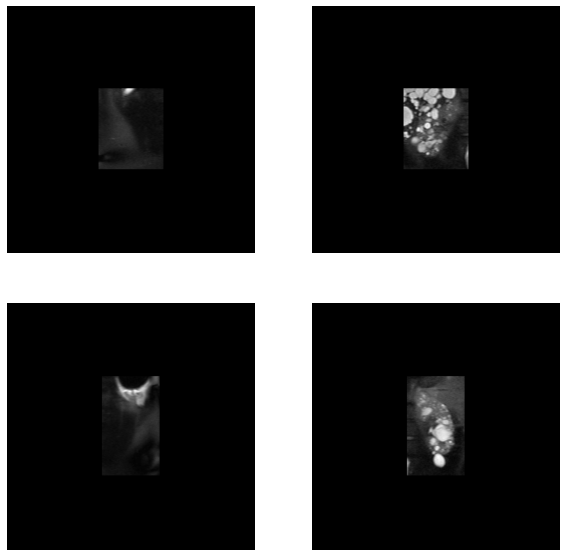

In [42]:
visualise_data_pred(prediction_set)

In [43]:
MR_K_predictions = model.predict(prediction_set)
MR_K_predictions = MR_K_predictions.astype('float')

In [44]:
def visualise_data(x, y):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(20,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    contours = measure.find_contours(y[50*i,:,:,0], .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    ax.axis('off')

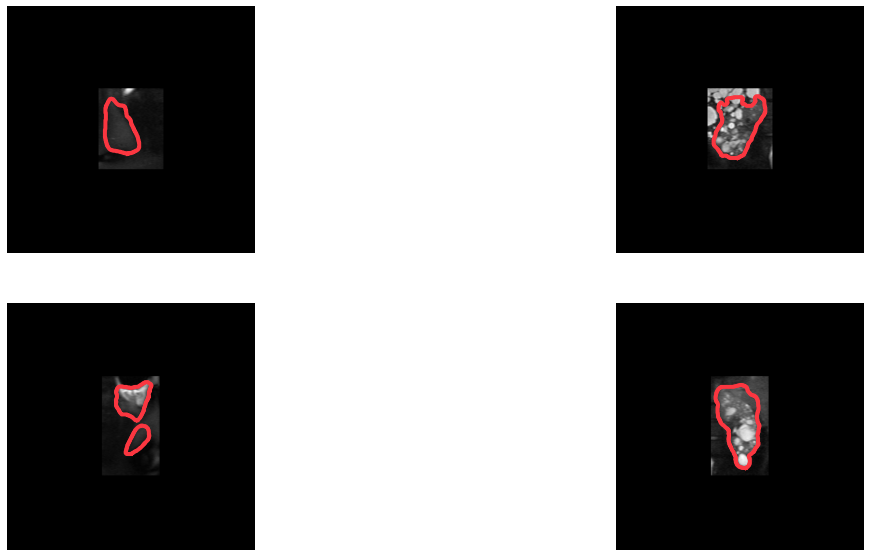

In [46]:
visualise_data(prediction_set, MR_K_predictions)

In [50]:
print(images[0])


101934_1_96_L_M.nii


In [52]:
image_og = nib.load(data_path+'\\'+images[0])
image_og = image_og.get_fdata()

In [55]:
print(image_og.shape[-1])

96


In [61]:
orig_filename = images[0]
orig_clip_fname = orig_filename[:-4]
print(orig_clip_fname)

101934_1_96_L_M


In [63]:
new_fname = '%s_K.nii' %orig_clip_fname
print(new_fname)

101934_1_96_L_M_K.nii


In [80]:
final_path = r'C:\Users\UAB\data\512_AllNII\Kidney Predict 50 epoch'
affine = np.eye(4)
new_set = MR_K_predictions[0:96,:,:,0]
nifti_file = nib.Nifti1Image(new_set, affine)
nib.save(nifti_file, os.path.join(final_path, "3_%s" %new_fname))

In [84]:
read_in = nib.load(r"C:\Users\UAB\data\512_AllNII\Kidney Predict 50 epoch\3_101934_1_96_L_M_K.nii")

In [85]:
read_test = read_in.get_fdata()

In [86]:
print(read_in.shape)

(96, 512, 512)


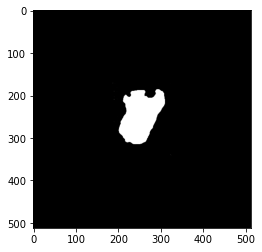

In [87]:
plt.imshow(read_test[50,:,:], cmap='gray')

In [88]:
#read in the real prediction and display 
real_in = nib.load(r"C:\Users\UAB\data\512_AllNII\101934_1_96_L_M_K.nii")
real_in_test = real_in.get_fdata()
print(real_in.shape)

(512, 512, 96)


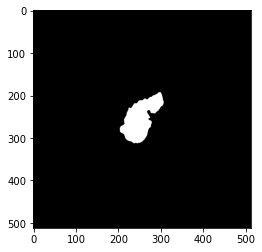

In [89]:
plt.imshow(real_in_test[:,:,50], cmap='gray')

(512, 512, 96)


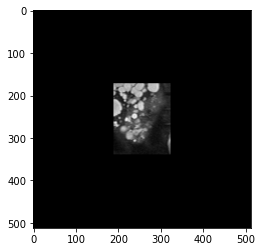

In [90]:
real_in = nib.load(r"C:\Users\UAB\data\512_AllNII\101934_1_96_L_M.nii")
real_in_test = real_in.get_fdata()
print(real_in.shape)
plt.imshow(real_in_test[:,:,50], cmap='gray')